In [3]:
import numpy as np

from scipy.stats import norm, multivariate_normal

import matplotlib.pyplot as plt
from corner import corner

from emcee.autocorr import integrated_time

# Toy Problem: target distribution

Let $P$ be the multivariate Gaussian distribution $\mathcal{N}(\mu,\Sigma)$ with mean $\mu=(0,0)$ and covariance matrix $((1,\beta),(\beta,1))$, with $\beta=0.99$. The PDF is

$$  P_\mathcal{X}(x,y) \propto \exp\left(\frac{-\left[x^2+y^2 - 2\beta x y\right]}{2[\beta^2-1]}\right) $$

In [4]:
def target_logPDF(x, y, beta=0.99):
    return -0.5*(x**2+y**2-2*beta*x*y)/(1-beta**2)

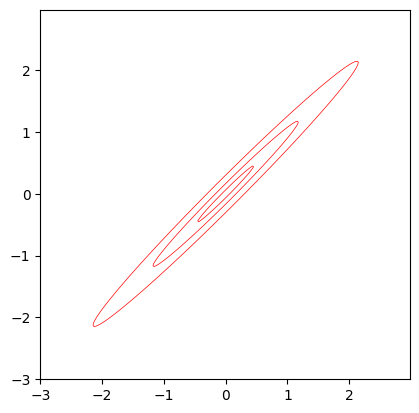

In [5]:
fig, ax = plt.subplots()
ax.set_box_aspect(1)

pts = np.arange(-3.0, 3.0, 0.02)
X, Y = np.meshgrid(pts, pts)
Z = np.exp(target_logPDF(X, Y))
ax.contour(X, Y, Z, levels=[0.1, 0.5, 0.9], colors='r', linewidths=0.5)

plt.show()

# Metropolis Hastings

We will consider three different proposal distributions:

$$ Q_\mathrm{Small} = \mathcal{N}\left(\begin{pmatrix}0\\0\end{pmatrix},\begin{pmatrix}0.1&0\\0&0.1\end{pmatrix}\right) $$

$$ Q_\mathrm{Large} = \mathcal{N}\left(\begin{pmatrix}0\\0\end{pmatrix},\begin{pmatrix}1&0\\0&1\end{pmatrix}\right) $$

$$ Q_\mathrm{Corr} = \mathcal{N}\left(\begin{pmatrix}0\\0\end{pmatrix},\begin{pmatrix}1&\beta\\ \beta&1\end{pmatrix}\right) $$

Note:
 - All of these proposal distributions are symmetric; therefore, we are implementing the Metropolis algorithm, a special case of the more general Metropolis-Hastings algorithm.
 - Our third proposal distribution is the same as the target distribution; i.e. we are stupidly using samples from P to produce samples from P! This toy example is included here to show how well MH can perform when have a good proposal.

In [6]:
cov_Qsmall = np.array([[0.05,0.],[0.,0.05]])
cov_Qlarge = np.array([[1.5,0.],[0.,1.5]])
cov_Qcorr_ = np.array([[1.,0.99],[0.99,1.]])

# Sampling

In [7]:
num_iter, num_accept = 50000, 0
chain = np.zeros((num_iter, 2))

chain[0] = np.array([+0,+0])                          # initialise
for i in range(num_iter-1):                           # sampling loop
    x_current = chain[i]                              # current position
    Q = multivariate_normal(x_current, cov_Qlarge)    # poposal distribution
    x_proposed = Q.rvs()                              # proposed position
    log_a = target_logPDF(*x_proposed) \
                - target_logPDF(*x_current)           # acceptance ratio
    u = np.random.uniform()                           # uniform random variable
    if np.log(u)<log_a:
        x_new = x_proposed                            # ACCEPT
        num_accept += 1                               # count how many proposals are accepted
    else:
        x_new = x_current                             # REJECT
    chain[i+1] = x_new                                # store new position in chain

# Examine the chain

In [8]:
print(f"Acceptance fraction = {num_accept/num_iter}")

Acceptance fraction = 0.08486


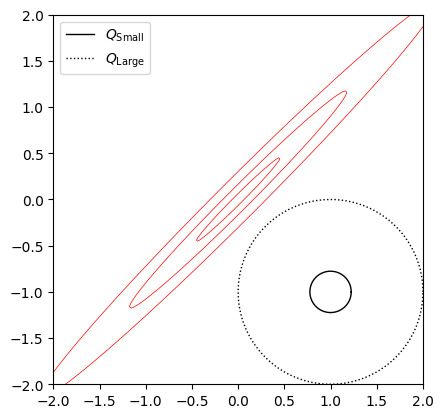

In [9]:
fig, ax = plt.subplots()
ax.set_box_aspect(1)

pts = np.arange(-3.0, 3.0, 0.02)
X, Y = np.meshgrid(pts, pts)
Z = np.exp(target_logPDF(X, Y))
ax.contour(X, Y, Z, levels=[0.1, 0.5, 0.9], colors='r', linewidths=0.5)

first_n_steps = 10
ax.plot(chain[0:first_n_steps,0], chain[0:first_n_steps,1])

phi = np.linspace(0, 2*np.pi, 100)
ax.plot(1.+np.sqrt(0.05)*np.cos(phi), -1.+np.sqrt(0.05)*np.sin(phi), 'k-', lw=1, label=r'$Q_{\rm Small}$')
ax.plot(1.+np.cos(phi), -1.+np.sin(phi), 'k:', lw=1, label=r'$Q_{\rm Large}$')

lim = (-2, 2)
ax.set_xlim(*lim)
ax.set_ylim(*lim)

plt.legend(loc='upper left')
plt.show()

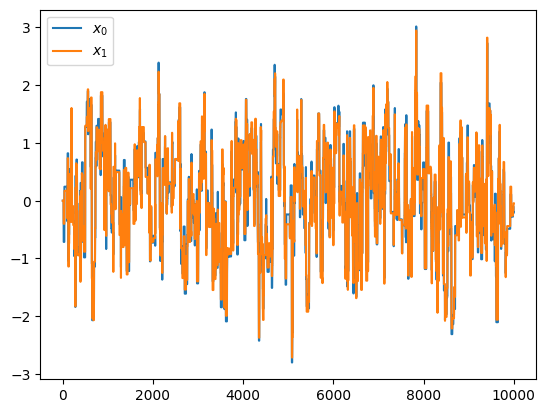

Correlation length estimate: (array([80.80061666]), array([80.05430856]))


In [10]:
fig, ax = plt.subplots()

first_n_steps = 10000

ax.plot(chain[0:first_n_steps,0], label=r'$x_0$')
ax.plot(chain[0:first_n_steps,1], label=r'$x_1$')

plt.legend(loc='upper left')
plt.show()

tau = integrated_time(chain[:,0]), integrated_time(chain[:,1])
print(f"Correlation length estimate: {tau}")

In [9]:
burnin = 0
thin = 2*int(np.max(tau))
samples = chain[burnin::thin,:]

print(f"Number of i.i.d. samples produced = {len(samples)}")

Number of i.i.d. samples produced = 261


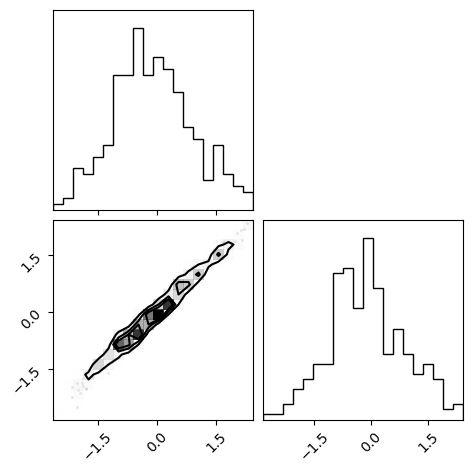

In [10]:
corner(samples)
plt.show()